<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [347]:
%%capture
pip install pyswarms

In [348]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [349]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'
DIAS_OBSERVADOS = 600

In [350]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [351]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [352]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [353]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [354]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [355]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [356]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [357]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [358]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [359]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


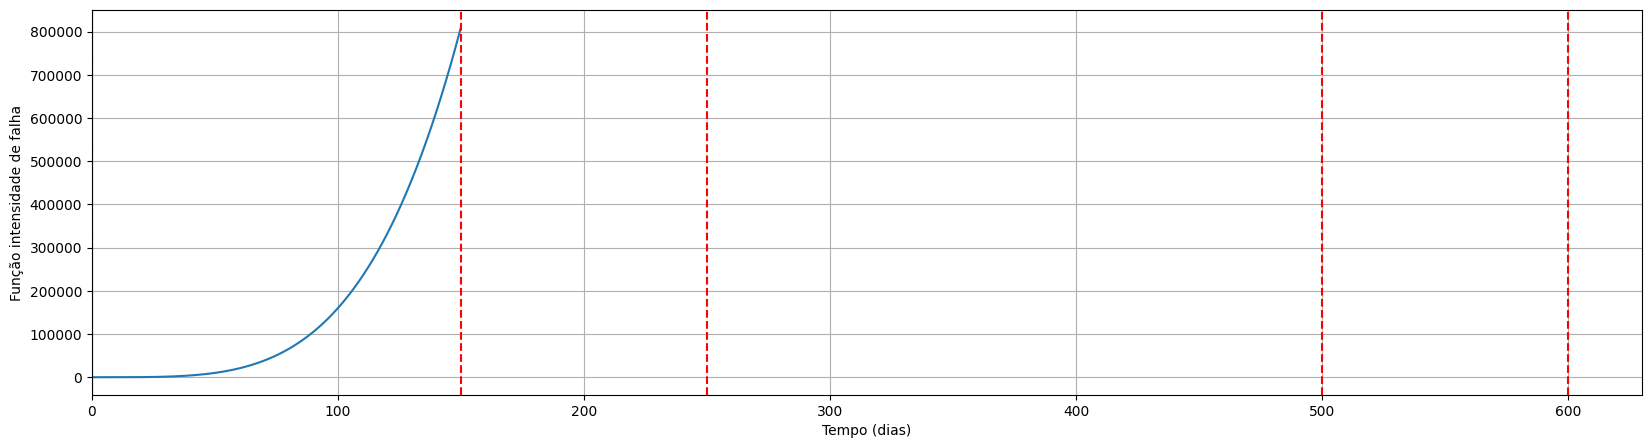

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [360]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [361]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [362]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-09-24 15:53:19,277 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   7%|▋         |7/100, best_cost=5.09e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 24, 40, 177, 196, 232, 327, 337, 399, 421, 480, 601, 641, 689]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 2548.0396800000003, 13088.531086351291, 34908337.00817171, 40651925.69140513, 44752864.25937768, 259954267.13465005, 260550266.80025995, 322369717.09866506, 467147925.48258, 1101982410.2202718, 1295078646.1277897, 1332388001.9677653, 3577246711.623318, 730250301.565968]
Custo =  410478273472.90393


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 114, 168, 248, 349, 380, 451, 494, 52

pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=5.09e+10



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 185, 311, 372, 460, 524, 648, 707]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 69343957.0, 372516830.40736055, 384064184.8186827, 552622710.2791834, 1530926212.0286489, 1783660666.0464559, 1875360783.6288393, 1521401487.911408]
Custo =  108288593276.85254


Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 20, 67, 182, 244, 461, 656]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 258259.4818009011, 17250395.62822385, 28230870.132

pyswarms.single.global_best:  40%|████      |40/100, best_cost=5.01e+10



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 67, 119, 126, 215, 394, 459, 642, 709]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 432040.03424, 3108997.731006266, 3165566.7572502326, 17634479.090650372, 210314902.69007602, 235387683.64156947, 1917213689.465682, 2029380702.1864767, 1668910857.743431]
Custo =  63448990420.18811


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 74, 124, 181, 313, 370, 391, 460, 535, 544, 639, 709]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.776869839851570

pyswarms.single.global_best:  48%|████▊     |48/100, best_cost=5.01e+10<ipython-input-361-3f464f4b430c>:83: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  56%|█████▌    |56/100, best_cost=5.01e+10



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 7, 67, 401, 459, 519, 603, 648]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 5.378240000000001, 362590.5694830516, 2361928136.7052417, 2456903950.215602, 2613870374.6392603, 2709106345.1970763, 2970057448.263319, 2803750481.0853252]
Custo =  86910496373.36789


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 65, 104, 318, 369, 410, 458, 525, 620, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.63212

pyswarms.single.global_best:  70%|███████   |70/100, best_cost=5.01e+10

Custo =  107910393470.4073


Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 76, 321, 460, 553, 632]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 811368.1203200001, 727142062.4356644, 1079186807.3758016, 2817937130.539639, 2917453070.272289, 2904535373.411872]
Custo =  103470402131.72414


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 1, 78, 180, 383, 407, 460, 487, 549, 576, 632, 692]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.77686983985157

pyswarms.single.global_best:  77%|███████▋  |77/100, best_cost=5.01e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 1, 71, 120, 238, 305, 397, 458, 523, 587, 645, 704]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 564072.9440171731, 930562.6930306992, 36742248.35586451, 44604609.423938334, 497052936.29867756, 1039125602.2221338, 1217739074.288172, 1272459691.124386, 1615897492.3736582, 4602411389.396639, 4258172886.7110653]
Custo =  310775391449.28076


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 65, 122, 308, 387, 410, 458, 530, 619, 647, 711]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5]
Núm

pyswarms.single.global_best:  92%|█████████▏|92/100, best_cost=5.01e+10



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 68, 215, 327, 409, 459, 646, 716]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 465258.74176000006, 85169089.30743702, 165721452.16901317, 266075761.762021, 718367248.7634834, 2500543221.4459577, 2624730433.9169645, 2241262262.4355283]
Custo =  104728619736.23483


Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 70, 90, 219, 304, 401, 460, 603, 645]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=4.57e+10
2023-09-24 15:53:20,780 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723146 4.85315293 3.85288229 0.52635115 4.63991228 2.40329822
 4.49248217 1.37414045 2.41798301 2.1136695  0.99760234 2.27563862
 2.90330098 4.21084211 5.13100543 5.28515503 2.82439642 5.00204649
 3.58074736 1.24442154 5.55152763 3.77787737 4.31322919 1.08625775]
2023-09-24 15:53:20,783 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


9 5
Tempos para manutenções preventivas: [0, 64, 306, 381, 412, 460, 516, 594, 602, 648]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 343597.38368, 600939384.7939531, 669453075.742644, 699152573.4848385, 774851679.9990798, 915893847.300669, 995411329.2085735, 999867745.2161901, 1046887263.966243, 1029355754.9849924]
Custo =  45673276964.32214


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 3, 64, 304, 421, 459, 505, 520, 540, 606, 650, 693]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.77686

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:20,812 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57775546 4.89597771 3.85270132 0.55349449 4.64065807 2.40297563
 4.49495154 1.37294593 2.40655539 2.11207563 0.99608974 2.26571554
 3.01116193 4.21056807 5.13407249 5.2880222  2.53797387 5.00671653
 3.58333489 1.17863668 5.55086344 3.77805966 4.31742042 1.0860943 ]
2023-09-24 15:53:20,816 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 68, 211, 301, 374, 427, 458, 486, 521, 546, 592, 610, 651]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 465258.74176000006, 76724063.48100299, 118168301.67997399, 402137607.4905486, 466826743.49879944, 750188106.3469671, 758591505.0952766, 773224944.7257936, 784423924.4333843, 818443159.9923075, 829949476.9354889, 1069254937.7104903, 1050941715.011103]
Custo =  95970442428.37349


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:20,857 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57774579 4.89405805 3.85269041 0.56048929 4.64071711 2.40293625
 4.49544811 1.37278083 2.40542111 2.11165609 0.9958592  2.26394384
 1.92214374 4.21052861 5.13487591 5.28845932 2.54092157 5.00663599
 3.5837322  1.17375821 5.55070146 3.7780683  4.31818661 1.08605939]
2023-09-24 15:53:20,858 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 77, 217, 431, 458, 519, 546, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 866170.93024, 83408577.31587963, 783228181.1907601, 1031179077.6235437, 1064651915.6549509, 1076991919.6949372, 1151526833.7804832, 1187527816.0276458, 1168704885.7505264]
Custo =  65812381655.604546


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:20,887 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57765245 4.88066897 3.85268326 0.55791275 4.64064424 2.40292381
 4.49513446 1.3727003  2.40457867 2.11167805 0.99572791 2.26336496
 0.3984091  4.21055412 5.13519388 5.2883176  2.61324941 5.00602266
 3.58326403 1.18547113 5.5507133  3.77802746 4.31750421 1.08605868]
2023-09-24 15:53:20,889 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 86, 222, 294, 327, 373, 434, 457, 505, 516, 621, 654, 684]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1505366.45632, 88440065.07256356, 114698517.80473733, 191852567.88530675, 372308694.4859039, 808324333.2999058, 840192634.0994381, 860940785.3526214, 864388862.2758521, 1498332122.0625815, 1529550607.6581192, 1562303242.9548826, 1281839801.8677812]
Custo =  111902628138.96878


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:20,919 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.5775002  4.86653377 3.85268109 0.54941494 4.64038634 2.40294512
 4.4940859  1.37295976 2.40402815 2.11196134 0.99562467 2.26575286
 5.95666878 4.21059722 5.13442304 5.28794651 2.71189161 5.00518126
 3.58252913 1.20993111 5.55090084 3.77796244 4.31664646 1.08611583]
2023-09-24 15:53:20,921 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 28, 226, 288, 433, 457, 514, 573, 625, 655, 679, 705]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 5507.317760000001, 153161271.875145, 158804849.47128227, 1175157896.1428287, 1394420523.3391235, 1423381282.4637744, 1467615197.0608413, 1516903472.5853238, 2677932082.4317513, 2702230939.978928, 2901596684.4121566, 2554123682.8676085]
Custo =  279625036159.22217


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 28, 230, 284, 375, 431, 457, 511, 627, 655, 679]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 5507.317760000001, 167823345.02958786, 237728492.22644156, 593803528.8894522, 984508884.9746307, 1221465216.55864, 1247473973.431489, 1447357726.4189525, 1472908055.0551746, 1497206912.6023514, 1232517512.2676713]
Custo =  118437037635.35251



2023-09-24 15:53:20,946 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57732138 4.85327167 3.85268918 0.53978464 4.6401164  2.40298071
 4.49288052 1.3732014  2.40388826 2.11240507 0.99563228 2.26799009
 3.72530311 4.21067099 5.1336878  5.28687317 2.80602191 5.00401934
 3.5813802  1.23744055 5.55119737 3.77788671 4.31508082 1.08620808]
2023-09-24 15:53:20,949 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:20,966 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57715015 4.84130755 3.85272039 0.52870723 4.63985599 2.40303878
 4.49175228 1.37348635 2.40428867 2.1130123  0.9958731  2.27122675
 0.79630869 4.21076425 5.13280523 5.2854368  2.89619472 5.00268084
 3.58031043 1.26417777 5.55148551 3.77781833 4.31355392 1.08630276]
2023-09-24 15:53



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 2, 114, 231, 284, 370, 428, 457, 562, 626, 655, 685]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.01024, 5985194.7171063945, 24743029.725066777, 93398398.45368071, 412482232.42079806, 805244082.8447651, 846386344.0061632, 964390786.5675536, 1032458457.6523625, 1200241712.9492123, 1233174817.0363226, 949552096.8295431]
Custo =  103269709132.34247


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 6, 112, 230, 289, 302, 424, 457, 504, 551, 573, 623, 655, 696]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2.4883200000000003, 5158771.154734372, 75803134.12959333, 157518929.88047564, 180292298.905659, 961290873.0616549, 969692981.2252321, 989642491.7469839, 1016876374.3019371, 1090678593.394375, 1343546844.257477, 1530166659.429567, 1582297602.3500154, 1263751475.9599416]
Custo =  121111422509.33926


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,009 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57700913 4.83157138 3.85274915 0.51873521 4.6396305  2.40313014
 4.49084548 1.37377565 2.40835321 2.11357628 0.99629782 2.27543299
 4.62016952 4.21086316 5.13147492 5.2840598  2.96080642 5.00143855
 3.57936864 1.28445312 5.55175195 3.77776983 4.31217371 1.08637949]
2023-09-24 15:53:21,012 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 2, 228, 293, 305, 421, 458, 481, 543, 575, 618, 654, 693]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 0.01024, 194327995.33426055, 200903524.58258995, 222821021.0096818, 944032005.624651, 998743637.4665071, 1005018409.4917669, 1045002868.7354226, 1063617439.0708115, 1269955121.4344401, 1480922710.3201642, 1528954868.8796117, 1219971378.6511831]
Custo =  108782799513.68651



2023-09-24 15:53:21,038 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57689543 4.82581716 3.85278309 0.51196604 4.6394821  2.40325159
 4.49025276 1.3740387  2.41425773 2.11410681 0.99705292 2.27927204
 0.84433443 4.21094992 5.13021323 5.28291165 3.01617502 5.00032997
 3.57869769 1.29977716 5.55194237 3.77773633 4.31122821 1.08642543]
2023-09-24 15:53:21,040 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,058 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57685937 4.82775308 3.85282632 0.50717574 4.63946463 2.40336578
 4.48997489 1.37428669 2.42001909 2.11452718 0.99780283 2.28265881
 4.23524528 4.21101861 5.12917381 5.28232428 3.03386513 4.99975699
 3.57825045 1.31006719 5.55208762 3.77772033 4.31073215 1.08646129]
2023-09-24 15:53



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 96, 225, 298, 311, 418, 458, 494, 576, 614, 653, 702]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 1862709.9558853272, 75267839.4596545, 103374569.00603537, 129005261.95421195, 775187296.8626378, 1137280339.1005046, 1208247634.305451, 1287028145.6270356, 1316781740.0270433, 1545858712.1578639, 1614386266.4392781, 1276600366.1463377]
Custo =  129360953399.15921


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,070 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57692982 4.83488523 3.85288172 0.50621776 4.63954767 2.40346617
 4.49037117 1.37447667 2.42508205 2.11471433 0.9984738  2.28529328
 6.89479075 4.21107187 5.12854703 5.28213026 3.00514652 4.9996024
 3.57802344 1.30270169 5.55214367 3.77773272 4.31048108 1.08647716]
2023-09-24 15:53:21,072 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 221, 414, 459, 502, 570, 611, 653, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 168698548.83232, 1624355845.5190217, 2033295181.2146528, 2125938895.1639478, 2180781772.0149117, 2213192784.2661605, 2461972777.5530624, 2553198860.3960767, 2186192792.1071267]
Custo =  127788946880.36403


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,087 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57701307 4.84505241 3.85293164 0.50677498 4.6396656  2.40352813
 4.49075855 1.37464408 2.42850667 2.11476534 0.99886373 2.28684152
 1.9650514  4.21107291 5.12852894 5.28250296 2.94790511 4.99990182
 3.57858032 1.28592301 5.5521033  3.77775698 4.31102379 1.08644349]
2023-09-24 15:53:21,088 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 4, 87, 218, 301, 377, 413, 459, 507, 609, 652]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 1477677.9589546935, 38293514.0445936, 74276130.58533853, 379208151.67627835, 385862821.6099442, 457174883.9436575, 566713515.3027406, 708227633.0614018, 752020041.4400955, 733450877.7843994]
Custo =  46098877940.18434


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,104 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57709662 4.85599899 3.85296457 0.51069363 4.63979502 2.40351525
 4.49161467 1.37477464 2.43032874 2.11480878 0.99916083 2.28721166
 3.92472354 4.2110656  5.12905385 5.28345271 2.89284611 5.00042084
 3.57929941 1.26766081 5.55193569 3.77780167 4.31181779 1.08638518]
2023-09-24 15:53:21,105 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 78, 216, 307, 412, 459, 502, 590, 608, 651, 718]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 923895.7977600001, 80630000.9510808, 125672335.92244211, 724146505.2885756, 797333050.3094231, 889976764.2587181, 986763449.9038061, 998125467.034819, 2603886364.578746, 2721061584.732278, 2330956310.970678]
Custo =  218500100928.44983


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,123 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57717842 4.86559485 3.85297676 0.51782739 4.63994601 2.4034585
 4.49250485 1.3748416  2.43147461 2.11460326 0.99902635 2.28550238
 5.54218275 4.21105396 5.12998086 5.28430839 2.83369762 5.00120821
 3.58034721 1.24678676 5.55171863 3.77784741 4.31271199 1.08630038]
2023-09-24 15:53:21,125 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 23, 71, 214, 300, 378, 413, 421, 459, 495, 547, 571, 609, 651, 695]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2059.6297600000003, 330020.3637296402, 32687577.413403604, 70531628.8796463, 386608130.3828987, 596355331.9262195, 597453219.229651, 654356346.9165238, 667009493.9253104, 697952413.7920513, 710551457.8564999, 880232673.3340367, 2449922826.179115, 2506928226.1515665, 2191573450.8055887]
Custo =  241113749884.90054


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,153 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57726767 4.87309605 3.85298276 0.52452704 4.64007761 2.4033945
 4.49329943 1.37476729 2.43146855 2.11440711 0.99849687 2.28143776
 6.5036681  4.2109983  5.13095808 5.28517796 2.77831848 5.00216595
 3.58137559 1.22785788 5.55150685 3.77789642 4.31364101 1.08621937]
2023-09-24 15:53:21,155 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 15, 68, 91, 213, 329, 414, 423, 459, 556, 610, 651]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 319173.4493467274, 397710.13250205264, 29456672.557538092, 66798204.487830535, 562490629.2989863, 563764413.281046, 617220737.6904058, 714530458.3127112, 762404199.2059906, 1001709659.980992, 983396437.2816046]
Custo =  64452789041.65182


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,176 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57734216 4.87946285 3.85296669 0.53060608 4.64016221 2.40331219
 4.49389314 1.37460943 2.42766163 2.11411485 0.99798506 2.27607168
 6.49026674 4.21090691 5.13184592 5.28595801 2.7367053  5.00302055
 3.58226255 1.21408098 5.55132244 3.77793822 4.31441211 1.0861568 ]
2023-09-24 15:53:21,178 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 17, 66, 213, 328, 380, 415, 425, 459, 510, 565, 611, 651]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 454.35424000000006, 257533.52415726814, 73459561.57835384, 159003932.4785481, 377716160.0783018, 412845677.91326195, 414305083.5035855, 464373514.60845333, 487964236.06620073, 525707338.3634125, 563784900.525875, 796598219.7909051, 778284997.0915178]
Custo =  64925390476.41052


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,208 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57739992 4.87910801 3.85293611 0.53491393 4.64023159 2.40323524
 4.49442633 1.3744291  2.42396859 2.11374744 0.99749602 2.2711642
 5.5689186  4.21080902 5.13254632 5.28643859 2.70126035 5.00359732
 3.58299843 1.20921846 5.55118469 3.77797385 4.31509009 1.0861215 ]
2023-09-24 15:53:21,210 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 65, 110, 214, 323, 419, 427, 458, 482, 512, 613, 651]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 371293.00000000006, 2065270.4894772859, 22167292.878361642, 258862701.94613498, 844765875.0884998, 901626957.4813591, 946341084.8771801, 953015237.1406667, 964166329.8980892, 1537385671.2107987, 1574256958.515206, 1555943735.8158188]
Custo =  98863836861.48306


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,230 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57742648 4.87640294 3.85289826 0.53654015 4.64025781 2.40317176
 4.49452885 1.37420344 2.41893424 2.11339616 0.99708022 2.26678183
 4.58499099 4.21072287 5.13316613 5.28681077 2.67690667 5.00396786
 3.58359327 1.20500506 5.55116202 3.77797983 4.31535717 1.08611929]
2023-09-24 15:53:21,236 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 66, 112, 216, 428, 458, 514, 614, 652, 703]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 400746.42432000005, 2261527.419149013, 22878300.972493168, 694933189.5187591, 969468009.4878747, 997603879.0388811, 1137202059.5893886, 1174281980.2423718, 1247130983.4670813, 906121454.2009864]
Custo =  80717489853.63336


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 15, 68, 110, 218, 314, 364, 429, 458, 494, 514, 616, 652, 718]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 243.00000000000003, 319173.4493467274, 1560119.195129752, 24608583.921735875, 44780894.85857344, 221806724.54571065, 307663911.11913365, 349156901.8574349, 361718530.3494742, 368496817.782809, 3306500611.7909727, 3341036698.3448606, 3455547860.3680015, 3065442586.6064014]
Custo =  168973789017.87155


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,260 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57742871 4.87206539 3.85286221 0.53762941 4.64027949 2.40313758
 4.49445322 1.37399789 2.41424456 2.11309456 0.99679329 2.2632875
 3.62705094 4.21067346 5.13362231 5.28669424 2.6565655  5.00404172
 3.58409373 1.20758552 5.55115033 3.77798113 4.31550872 1.08613193]
2023-09-24 15:53:21,264 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 22, 72, 221, 428, 458, 513, 618, 653, 689]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 365550.2252260123, 39578187.69515118, 675799455.9285157, 950334275.8976314, 977480715.3143502, 1134116076.3784904, 1167598897.254437, 1209967903.8430672, 913686610.9562199]
Custo =  79772511785.58566



2023-09-24 15:53:21,291 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57737831 4.86631402 3.85282981 0.53828667 4.6402793  2.40313506
 4.4939371  1.37384149 2.4109869  2.11291277 0.99655138 2.26376205
 2.58959569 4.21067028 5.13331467 5.28642538 2.66690441 5.00403635
 3.58400374 1.21169354 5.55121335 3.7779631  4.31497653 1.08614906]
2023-09-24 15:53:21,294 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,314 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57729226 4.85825614 3.85281366 0.53562205 4.64021724 2.4031474
 4.49334774 1.37371402 2.40887944 2.11292404 0.99641893 2.26513164
 1.72927813 4.21067037 5.13264587 5.2860292  2.72104617 5.00374735
 3.5834216  1.2210786  5.55131428 3.77792917 4.3143238  1.08617997]
2023-09-24 15:53:



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 77, 223, 298, 328, 378, 427, 457, 512, 619, 654]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 866170.93024, 97186370.06265289, 126557890.40432349, 197857598.04063654, 404081010.51966715, 462710279.52329445, 734834693.9383837, 761802539.0087522, 925202041.1853994, 958875194.8051901, 939800589.7045783]
Custo =  84655191090.92484


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,340 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57721217 4.84959275 3.8528125  0.53264816 4.64015986 2.40320163
 4.49263956 1.37363327 2.40917181 2.11299813 0.99652808 2.26817093
 1.00414118 4.21067115 5.13201012 5.28550551 2.78669313 5.00340914
 3.58270497 1.23128528 5.5514276  3.77788522 4.31356149 1.08622707]
2023-09-24 15:53:21,341 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 82, 224, 297, 361, 425, 458, 490, 511, 573, 620, 654, 717]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1186367.49824, 95891461.35267189, 123680637.7859929, 340529576.90429, 759922588.9035478, 1060887209.1987195, 1071245940.5627958, 1078281185.9254022, 2440783503.387045, 2482153653.0523605, 3785344027.2363014, 3891555409.648337, 3504772592.0072393]
Custo =  347836565003.4371


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,365 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57714365 4.84219913 3.85281872 0.52917086 4.64010132 2.40325522
 4.49198379 1.37363084 2.40993102 2.11317856 0.99689464 2.27131696
 0.79832143 4.21069618 5.13132336 5.28498552 2.85172131 5.00296757
 3.58199008 1.24265403 5.55154733 3.77784511 4.31281941 1.08627387]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 17, 87, 116, 224, 296, 305, 423, 458, 505, 566, 581, 620, 654, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 454.35424000000006, 1143666.9906826315, 1403313.2566256074, 26208907.67654488, 34751084.79389827, 51288402.94339671, 799115241.1988218, 808320938.0471725, 828408032.1680523, 873166831.5238043, 1236938098.0065343, 1424185145.1698015, 2727375519.353742, 2769973253.4892964, 2470520982.0548453]
Custo =  327460227860.08276


2023-09-24 15:53:21,370 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,390 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57709832 4.83593502 3.85283162 0.52548576 4.6400234  2.40331099
 4.49144117 1.37376413 2.4122751  2.11345345 0.99742947 2.27417518
 1.11078191 4.21073401 5.13063621 5.284551   2.9040079  5.00241155
 3.58122627 1.25322413 5.55164963 3.77781712 4.3122261  1.08631497]
2023-09-24 15:53:21,396 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 224, 296, 421, 458, 560, 588, 619, 654]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 180463788.35968003, 329180939.7201952, 1107646059.4064279, 1443628628.6132138, 1553657312.0554655, 1570697959.6885877, 1715209133.9027257, 3055575957.4030533, 3036501352.3024416]
Custo =  252711501581.48505


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,415 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57707812 4.83369988 3.85284721 0.52222994 4.63995107 2.40335788
 4.49101733 1.37390726 2.41545671 2.11375752 0.99792878 2.27714322
 1.6418033  4.21076848 5.1300719  5.28420974 2.93106468 5.0018884
 3.58040477 1.2602369  5.55170953 3.77780992 4.31196518 1.08634497]
2023-09-24 15:53:21,420 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 9, 95, 223, 298, 327, 420, 458, 486, 554, 592, 618, 654, 700]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 18.895680000000002, 2112848.7551460215, 25768265.561052002, 55139785.90272261, 123313147.89330205, 696713950.7355863, 707086768.0345987, 715490166.7829082, 765412058.1455878, 917424943.5951263, 1036184635.9462595, 2413671820.041383, 2475832323.8239427, 2144478375.976198]
Custo =  247684189862.15192


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,443 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57708937 4.83619904 3.85286286 0.52041481 4.6398782  2.40338505
 4.49088002 1.37406142 2.41849374 2.11401013 0.9983539  2.27973676
 2.23760528 4.21081182 5.12969388 5.28395362 2.94867413 5.00143422
 3.57974418 1.26628453 5.55175785 3.77781547 4.31207819 1.08636279]
2023-09-24 15:53:21,444 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 110, 222, 373, 420, 458, 504, 550, 593, 617, 654, 695]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 5153632.0, 75189008.73618197, 178870250.78319752, 476565891.6484172, 821265890.0425088, 840570817.9273633, 866783164.256166, 1042672021.9958822, 1151002232.5480757, 2565554488.6373878, 2617410895.8010187, 2302056120.455041]
Custo =  276691841247.5885


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,477 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57710943 4.83914651 3.85288206 0.51962694 4.63982123 2.40340111
 4.49087426 1.37420419 2.42111976 2.11415026 0.99865862 2.2813681
 2.83301123 4.21085344 5.12970436 5.28405093 2.93733829 5.00111688
 3.57924784 1.2667489  5.55177991 3.77782808 4.31246803 1.086368  ]
2023-09-24 15:53:21,482 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 104, 221, 458, 547, 593, 616, 654, 705]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 3893289.2876800005, 75981345.35769334, 2312601538.596321, 3907689331.7124557, 3941913620.871238, 4044787648.362419, 5496350486.396454, 5569946643.714201, 5222473642.169653]
Custo =  304725057633.70886


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 8, 220, 364, 458, 546, 587, 615, 654]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 10.48576, 155265050.60886306, 241062046.29444897, 1062143417.4572481, 1373907369.1451066, 1401946821.789388, 1528125130.7132301, 3016644857.6273313, 2997570252.5267196]
Custo =  229266160636.66205


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,518 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57713336 4.84267928 3.85289935 0.52039374 4.63977879 2.403406
 4.49112781 1.37432538 2.42295661 2.11418848 0.99880632 2.28157906
 3.37505572 4.21088812 5.12991853 5.28417148 2.90909858 5.00093698
 3.57918187 1.2613747  5.5517863  3.77783993 4.31296242 1.0863628 ]
2023-09-24 15:53:21,519 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,564 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57718176 4.84667047 3.85291315 0.52281049 4.6397569  2.40338872
 4.49157713 1.37442482 2.42316461 2.1141967  0.99868006 2.28083089
 3.77881016 4.21091106 5.13019833 5.28448762 2.87261029 5.00099825
 3.57917559 1.25430136 5.5517309  3.77785714 4.31342196 1.08634243]
2023-09-24 15:53:21,567 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


5
Tempos para manutenções preventivas: [0, 219, 387, 420, 458, 498, 547, 581, 614, 654, 693]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 161202047.07168, 1128677086.8410115, 1340822636.4783168, 1397251320.5198681, 1412286208.210216, 1440544308.7094035, 1565426195.8145437, 1715319445.2287266, 3240743163.380233, 3288775321.9396806, 2979791831.7112517]
Custo =  265063422225.15228


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 88, 218, 422, 458, 486, 550, 575, 614, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1688742.13376, 78607900.2679566, 670817017.8703506, 998067715.0347905, 1006471113.7831, 1050465240.1895074, 1136248234.1482599, 1316554905.5164819, 2795917994.4122357, 2777095064.135116]
Custo = 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,621 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722738 4.85026766 3.85291706 0.52585482 4.63977225 2.4033652
 4.49211122 1.37444155 2.42191572 2.11411187 0.99854992 2.27943476
 4.02163647 4.21092591 5.13045184 5.28482791 2.82806342 5.00126628
 3.57922544 1.24660218 5.55166565 3.7778753  4.31382058 1.08630097]
2023-09-24 15:53:21,623 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 239735172957.65878


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 20, 83, 218, 310, 360, 424, 458, 510, 554, 614, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 834180.25789041, 40598466.61689715, 87986105.47504202, 257273781.93460423, 276243057.4325109, 285076115.91466075, 309401542.61055046, 334601592.0853856, 392150657.6387947, 621227629.7696152, 602404699.4924957]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,683 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57726911 4.85407477 3.8529109  0.52863819 4.63979879 2.40334102
 4.49265719 1.3744051  2.42045013 2.11396737 0.9981713  2.27706422
 4.08238217 4.21093836 5.1308274  5.28523057 2.78748109 5.00155425
 3.57961648 1.23910568 5.55159722 3.77789176 4.31412061 1.0862525 ]
2023-09-24 15:53:21,688 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  51973792939.718216


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,725 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57729791 4.85730406 3.85289722 0.53079978 4.63982743 2.40331611
 4.49314181 1.37434303 2.41865084 2.11380364 0.9977427  2.27466598
 3.87673636 4.21094162 5.13117941 5.28557585 2.7590007  5.00190017
 3.58009813 1.23294987 5.55151597 3.77790404 4.31431625 1.08621024]
2023-09-24 15:53:21,729 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 80, 218, 366, 425, 458, 511, 558, 614, 652, 713]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1048576.0, 83589939.42908789, 280547160.35822093, 668574432.1611516, 677042798.8325814, 702284485.243083, 730755062.4302653, 782502567.4123136, 1003762826.1422852, 1103010972.1881738, 729441596.3239148]
Custo =  86148138508.93025


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,813 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57731677 4.85966139 3.8528825  0.53263225 4.63987438 2.40329302
 4.49341604 1.37426444 2.41699494 2.11365564 0.99733369 2.2725483
 3.41272188 4.21092248 5.13145475 5.28583971 2.73383223 5.00225201
 3.5806771  1.23075425 5.55144523 3.77791017 4.31436376 1.08617581]
2023-09-24 15:53:21,816 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 15, 77, 94, 218, 327, 426, 458, 511, 562, 614, 652, 717]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 621743.6747852336, 677131.4043628101, 32753632.681842797, 281187092.7228089, 926654190.3648684, 972999275.8583899, 998240962.2688915, 1031232899.01501, 1077532533.235321, 1298792791.9652927, 1410133677.569411, 1023350859.9283137]
Custo =  93497150832.54926


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 76, 219, 427, 458, 511, 564, 615, 652]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 811368.1203200001, 88509815.6075268, 727707789.6044775, 1011069152.4526452, 1036310838.8631468, 1071733960.6836896, 1116983767.9828978, 1331826448.8181825, 1313257285.1624863]


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10

Custo =  84132946875.74213


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:21,920 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57732937 4.86105701 3.85286925 0.53339436 4.63991838 2.4032726
 4.49353119 1.374192   2.41563164 2.11352275 0.99697512 2.27132364
 2.98684007 4.21089756 5.13164728 5.28603139 2.71596841 5.00255941
 3.5812072  1.23037477 5.55138698 3.77791407 4.31418126 1.08615424]
2023-09-24 15:53:21,952 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 78, 103, 220, 326, 382, 427, 458, 509, 511, 566, 616, 652, 712]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 923895.7977600001, 1681177.838982502, 30185347.310698718, 268476177.6560175, 508271347.53276616, 561075637.9985614, 605789765.3943824, 629222395.630861, 629773900.1745583, 1785856995.4959822, 1830065289.277724, 2038527012.9746404, 2134894892.965637, 1764610643.9297683]
Custo =  171094339120.14676


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,134 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57731655 4.86163901 3.85285975 0.53257976 4.63995696 2.4032616
 4.49332371 1.37411806 2.41454904 2.11343113 0.9967109  2.27072062
 2.58992726 4.21086911 5.13165636 5.28606062 2.72546812 5.00275718
 3.58167441 1.23283354 5.55135483 3.77790766 4.31376222 1.0861589 ]
2023-09-24 15:53:22,137 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,162 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57729283 4.86173456 3.85285485 0.53044167 4.6399832  2.40326088
 4.49309337 1.37405173 2.41400356 2.11335607 0.99655491 2.27119703
 2.25682471 4.2108361  5.13150044 5.28587115 2.73783137 5.00278929
 3.58199229 1.238



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 80, 100, 221, 298, 427, 458, 511, 568, 572, 616, 652]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 813779.8577093846, 838060.0186949179, 32114677.324393775, 42310274.15614308, 892968242.0747881, 1176329604.9229558, 1201571291.3334572, 1242218963.8729033, 1243977760.6545532, 1453118737.0501602, 2813705387.075405, 2795136223.419709]
Custo =  242689883138.75735


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,194 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57725768 4.8606311  3.85285541 0.52795445 4.64000113 2.40326284
 4.49275183 1.37399726 2.414435   2.11334337 0.99663441 2.27229822
 1.96099259 4.21080792 5.1312584  5.28557164 2.76019615 5.00277995
 3.58216745 1.24307806 5.55140171 3.77789172 4.31284404 1.08618067]
2023-09-24 15:53:22,197 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 83, 104, 222, 297, 426, 458, 511, 567, 578, 617, 652]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 987462.0806502082, 1475389.6406926552, 31260503.89812924, 146701905.4957908, 989490617.3111, 1281661785.2104387, 1306903471.6209402, 1346198374.7526302, 1351562617.7832644, 1535314845.5949414, 2859239113.5589128, 2840669949.903217]
Custo =  248212368631.0331


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,224 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722509 4.85834342 3.85286242 0.52545165 4.63999698 2.40326695
 4.49237587 1.37395914 2.41484565 2.11341041 0.9969564  2.27392633
 1.9246002  4.2107925  5.1310196  5.28517818 2.78948818 5.00266175
 3.58208324 1.24792552 5.55143351 3.77788412 4.31245235 1.08620929]
2023-09-24 15:53:22,226 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 87, 223, 296, 326, 376, 424, 458, 510, 564, 582, 618, 652, 707]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1594946.9462400002, 90036168.4703674, 117510557.88644493, 187069328.7927117, 388914321.5135672, 704529210.0560348, 1014271314.188728, 1038596740.8846177, 1075056251.8822541, 1084663322.6547804, 1253848558.4041882, 2541054953.779414, 2623838381.8869133, 2269879086.169482]
Custo =  288537519452.76465


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,251 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57719692 4.85613313 3.85287235 0.52330709 4.63997347 2.40327226
 4.49204916 1.3739344  2.41597715 2.11353913 0.99730209 2.27585281
 2.00748977 4.2107901  5.13080335 5.28482378 2.82462087 5.00248844
 3.58178629 1.25215036 5.55147598 3.77787688 4.3122448  1.08624588]
2023-09-24 15:53:22,254 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 89, 223, 298, 366, 423, 458, 484, 510, 560, 586, 618, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1786899.02368, 88708158.61536957, 118079678.95704018, 361091416.2264987, 729451941.790287, 1047955944.227222, 1055467750.9104328, 1064589690.5578874, 1232607776.6448858, 1247942249.7704668, 1396598408.124889, 2728724914.639446, 2709901984.362326]
Custo =  271391866530.7024


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57717908 4.85378364 3.8528829  0.5216897  4.63994055 2.40328405
 4.49178915 1.37395564 2.41744404 2.11368618 0.99769706 2.27757763
 2.08306275 4.21079041 5.13066495 5.28451491 2.85623564 5.00222216
 3.58144031 1.25414183 5.55151756 3.7778705  4.31220879 1.0862812 ]
2023-09-24 15:53:22,290 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 106, 223, 315, 367, 422, 458, 492, 555, 586, 617, 653]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 51.53632, 3598268.3503116146, 21210646.624047615, 71114351.37549761, 261101579.30957708, 326006105.7993741, 653256802.963814, 664684643.8594714, 708856332.8676558, 825508882.861921, 968202171.8319991, 2337219515.5710278, 2318396585.293908]
Custo =  249765923343.2918


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,306 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57717836 4.85161436 3.85289235 0.52091748 4.63990688 2.40329481
 4.49163752 1.37399418 2.41892112 2.11381605 0.9980421  2.27885518
 2.22735958 4.21079582 5.13055783 5.28426852 2.87568654 5.00195872
 3.58108568 1.25468746 5.55155687 3.7778662  4.31218614 1.0863086 ]
2023-09-24 15:53:22,308 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 222, 304, 372, 421, 458, 495, 551, 586, 617, 653]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172549955.08224002, 358817977.328295, 618313867.1758687, 931092637.0433991, 1267075206.250185, 1280228883.020671, 1315853872.9862285, 1449182888.1723335, 1591876177.1424117, 2960893520.8814406, 2942070590.604321]
Custo =  280465056284.6246


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,336 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57717984 4.84999916 3.85290015 0.5207809  4.63987699 2.40330532
 4.4916443  1.37406694 2.42003927 2.11391351 0.99822855 2.27968529
 2.50867063 4.21081149 5.13047769 5.28424963 2.88636531 5.00174271
 3.58068764 1.25414797 5.55159205 3.77786419 4.31225459 1.08632812]
2023-09-24 15:53:22,338 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 112, 222, 329, 387, 421, 458, 492, 548, 583, 616, 653]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 5639493.386240001, 74362490.58499731, 323881791.73032606, 585247263.4456925, 591790777.6218861, 927773346.828672, 939201187.7243295, 974168122.6266041, 1104860698.860309, 1256669346.5821652, 2662522536.0377874, 2643699605.760668]
Custo =  257729884273.7574


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 23, 88, 221, 326, 421, 458, 485, 547, 581, 616, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 1077995.9496336195, 40646830.998185806, 111327612.85867357, 702437002.2097338, 757148634.05159, 765099336.178965, 806077477.3514832, 930959364.4566234, 1092906700.990403, 2498759890.446025, 2479936960.1689053]
Custo =  225179413509.75034


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,383 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57718535 4.8494057  3.85290326 0.52160764 4.63985152 2.40331449
 4.49181905 1.37414154 2.42082783 2.11393532 0.99830545 2.27992283
 2.76795244 4.21083347 5.1304703  5.28447245 2.89302577 5.00161807
 3.58033961 1.25233399 5.5516187  3.77786269 4.31238296 1.08634244]
2023-09-24 15:53:22,384 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 86, 220, 316, 367, 422, 458, 548, 579, 615, 653, 711]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1505366.45632, 84032212.02008617, 138409138.9372409, 324904976.7070293, 677522678.1154213, 730532105.5949895, 810881380.6454978, 829206115.1744381, 995215317.0907564, 2437850156.7786717, 2529076239.621686, 2162070171.332736]
Custo =  246715420726.33026


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,413 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57720068 4.84945012 3.85290465 0.52374112 4.63983325 2.40332262
 4.49207019 1.37420861 2.42096801 2.11388662 0.99825945 2.27970735
 3.02880711 4.21085561 5.13047481 5.28479822 2.8843234  5.00155585
 3.58005971 1.24838306 5.5516389  3.77786366 4.31269326 1.08634102]
2023-09-24 15:53:22,414 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 1, 84, 220, 384, 423, 458, 550, 576, 615, 653, 710]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 0.00032, 1312221.4403993096, 29704012.073615998, 310684780.9692179, 566986788.87486, 618308658.8877378, 703115977.5281727, 717490485.8309202, 898940231.1812987, 2341575070.869214, 2430073091.9042583, 2066338433.2450924]
Custo =  235706606074.47363


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,444 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57721453 4.85015246 3.85290435 0.52607562 4.63983522 2.4033274
 4.49240708 1.37425223 2.42038229 2.11380559 0.9980658  2.27922502
 3.26237873 4.2108743  5.13053935 5.28510571 2.85888311 5.00163535
 3.57997173 1.24392687 5.55163737 3.77786807 4.3129919  1.08631996]
2023-09-24 15:53:22,449 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 82, 113, 219, 328, 423, 458, 554, 574, 615, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1186367.49824, 2528224.50264134, 24883233.051771723, 276319784.715184, 878796051.7615354, 930117921.7744131, 1024409636.6737945, 1034722997.1933178, 1226626607.5525727, 2669261447.240488, 2650438516.9633684]
Custo =  219525102950.84332


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,474 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.5772296  4.85150197 3.85289792 0.52825046 4.63984962 2.4033281
 4.49271698 1.37426898 2.41929693 2.11370951 0.99775874 2.27856759
 3.47206856 4.21089105 5.13060376 5.28539452 2.83012027 5.00175438
 3.58005503 1.24006188 5.55163526 3.77787403 4.31331139 1.08628315]
2023-09-24 15:53:22,482 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 82, 116, 219, 313, 424, 458, 510, 557, 572, 615, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1186367.49824, 2809323.0041736895, 23756356.3450931, 74543413.69375162, 784234016.533866, 1093976120.6665592, 1118301547.362449, 1146592902.0955405, 1153878421.2782936, 1356367291.7893693, 2799002131.4772844, 2780179201.200165]
Custo =  243572959118.53308


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,511 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57724342 4.85283642 3.85289112 0.53001075 4.6398766  2.4033278
 4.49293028 1.37425812 2.41816148 2.1136117  0.99744284 2.27729216
 3.6190151  4.21090288 5.13070054 5.28560659 2.80327049 5.00192929
 3.58020515 1.23740858 5.55161498 3.77787999 4.31358143 1.08624993]
2023-09-24 15:53:22,514 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 28, 82, 219, 424, 458, 510, 560, 572, 616, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 5507.317760000001, 657713.3832869848, 42422291.5539964, 649022371.1313176, 958764475.2640108, 983089901.9599005, 1014712073.7314734, 1020382054.1286448, 1229523030.524252, 2635376219.9798737, 2616553289.702754]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,540 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.5772537  4.85409939 3.85288266 0.53055468 4.63990553 2.40332434
 4.49301886 1.37423087 2.41711767 2.11353219 0.99716767 2.2758231
 3.71981444 4.21090165 5.13084405 5.28569877 2.78280708 5.00210431
 3.58042998 1.2357065  5.55157766 3.77788495 4.3137759  1.0862204 ]
2023-09-24 15:53:22,546 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  228253347160.43976


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 7, 83, 219, 319, 385, 425, 458, 510, 563, 573, 616, 653]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 5.378240000000001, 1094739.2510009282, 72887194.43857968, 133223175.2985655, 422894620.65238357, 467916680.2239136, 515906577.5355074, 540232004.231397, 575438160.7039542, 580109700.2706724, 783875455.2703725, 2189728644.7259946, 2170905714.448875]
Custo =  211214164958.17105



2023-09-24 15:53:22,571 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57725948 4.85510291 3.85287505 0.53017251 4.63993304 2.40331903
 4.49300878 1.37419392 2.416258   2.11349112 0.99694182 2.27444574
 3.7579765  4.21088901 5.13100163 5.28576088 2.77014837 5.00225623
 3.58072069 1.23456014 5.55154141 3.77788771 4.31382894 1.08619805]
2023-09-24 15:53:22,574 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,599 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57725815 4.85586759 3.85286981 0.52974614 4.63995396 2.40331174
 4.49294862 1.37414479 2.41549171 2.11345502 0.9967723  2.27351242
 3.59916254 4.21087419 5.13114398 5.28568453 2.7646686  5.00237179
 3.58098794 1.23387319 5.5515054  3.77788873 4.31386    1.08619445]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 84, 220, 374, 425, 458, 510, 564, 574, 616, 652, 714]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1338278.2156800001, 85320728.59159015, 313230111.80469733, 650859975.2700315, 698849872.5816252, 723175299.2775149, 759634810.2751513, 764338304.7419229, 962762530.6844459, 2323349180.709691, 2425533933.803363, 2048672310.7999043]
Custo =  237094164623.62494


2023-09-24 15:53:22,601 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 85, 92, 220, 300, 361, 424, 458, 510, 566, 576, 616, 652]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1419857.0, 1570686.1423979006, 37090564.473388456, 48470054.61810812, 255545562.21499318, 273966333.5321717, 323615093.0954823, 347940519.791372, 386997993.9819596, 391765890.0179055, 579606719.7026172, 1940193369.7278624, 1921624206.0721662]
Custo =  200378243375.671


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57725195 4.85600206 3.85286753 0.52915485 4.63996909 2.40330291
 4.49276755 1.37410004 2.41503227 2.11344784 0.99671489 2.2728533
 3.41904734 4.21085986 5.13126455 5.28553709 2.76355853 5.00239893
 3.5812176  1.23365666 5.55147899 3.77788863 4.31379238 1.08619129]
2023-09-24 15:53:22,634 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 14, 86, 221, 317, 424, 458, 510, 567, 578, 617, 652]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 172.10368000000003, 1142653.4195443802, 74510084.34938045, 129440783.46208498, 813545361.3205692, 1123287465.4532623, 1147612892.149152, 1188016069.1280007, 1193380312.158635, 1377132539.9703119, 2701056807.9342833, 2682487644.2785873]
Custo =  244777942606.12466



2023-09-24 15:53:22,664 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57724365 4.85591587 3.85286622 0.52798879 4.63997345 2.40329381
 4.4925789  1.37406319 2.4151363  2.11345597 0.99669288 2.27291584
 3.15091356 4.21084351 5.13134022 5.28538233 2.7699847  5.00236689
 3.58133146 1.23553073 5.55146398 3.77788781 4.3137184  1.08619256]
2023-09-24 15:53:22,666 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,692 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723494 4.85534004 3.85286858 0.52669532 4.63996625 2.40328602
 4.49238213 1.37403472 2.41601873 2.11347224 0.99684312 2.27316205
 2.87000297 4.21082867 5.13131017 5.28517611 2.79202013 5.00228938
 3.58135511 1.23831986 5.55146212 3.77788638 4.31352151 1.0862094 ]
2023-09-24 15:53



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 87, 221, 309, 423, 458, 510, 567, 580, 617, 652]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1594946.9462400002, 85566647.37374277, 128939409.31541213, 851095246.8247094, 860300943.6730602, 884626370.3689499, 925029547.3477987, 931571884.4610797, 1104871808.9709232, 2428796076.9348946, 2410226913.2791986]
Custo =  209130999355.2059


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,722 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722619 4.85423626 3.85287356 0.52545449 4.63995433 2.40328168
 4.49222483 1.37401083 2.41717482 2.11352425 0.9970998  2.27387038
 2.61795731 4.21081548 5.13127568 5.28498856 2.81623488 5.00214714
 3.58131929 1.24095507 5.55147728 3.77788277 4.31327225 1.08623301]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 8, 88, 105, 222, 307, 423, 458, 510, 566, 580, 617, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 10.48576, 1450406.9009848784, 1532917.2539000004, 30718621.487736847, 44726615.52197841, 779693661.3590918, 1098197663.7960267, 1122523090.4919164, 1161580564.682504, 1168690238.6131341, 1341990163.1229777, 2711007506.8620067, 2692184576.584887]
Custo =  242454197384.1416


2023-09-24 15:53:22,725 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 88, 91, 222, 423, 458, 480, 564, 581, 617, 653, 693]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1688742.13376, 1753078.5247012745, 40258733.4268465, 1389365303.4396718, 1707869305.8766067, 1713757256.238277, 1790808372.5347643, 1850182694.0362186, 2018304223.5174756, 3387321567.2565045, 3436981073.8651514, 3127997583.6367226]
Custo =  272345476433.7987



2023-09-24 15:53:22,760 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57721889 4.85299029 3.85288062 0.52435016 4.63994171 2.40328059
 4.49210439 1.37399081 2.41828297 2.11359425 0.99740554 2.2749258
 2.46768024 4.21080586 5.13120981 5.28485999 2.84010346 5.00201556
 3.58117936 1.24346355 5.55149891 3.77787915 4.31303899 1.08625763]
2023-09-24 15:53:22,764 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 88, 222, 304, 389, 423, 458, 482, 562, 580, 617, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1688742.13376, 87125182.3238509, 123545014.14597546, 509307549.5027795, 733995376.5298103, 1052499378.9667451, 1059173531.2302318, 1128823238.6781716, 1191440015.4152095, 1364739939.9250531, 2733757283.664082, 2714934353.3869624]
Custo =  276169978694.963


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,791 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57721541 4.85190466 3.85288702 0.52369655 4.63992248 2.40328486
 4.49207529 1.37401189 2.41924927 2.11366084 0.9976844  2.27593385
 2.41051157 4.21080076 5.13110512 5.28477741 2.85938442 5.00190307
 3.58104133 1.24592456 5.55151912 3.77787568 4.31286352 1.08627981]
2023-09-24 15:53:22,793 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 87, 221, 303, 422, 458, 483, 558, 579, 617, 653, 694]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1594946.9462400002, 85566647.37374277, 121591953.59052396, 868793200.9731994, 878379634.4437058, 885466028.8634374, 946081090.9105636, 1019264069.5661705, 1197774110.7835996, 2566791454.522629, 2618374416.9700384, 2306207124.3139825]
Custo =  238044458790.5105


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,821 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57721391 4.85107402 3.85289186 0.52338038 4.63990294 2.4032897
 4.49215857 1.37404329 2.42005312 2.11372208 0.99791927 2.27676017
 2.45328961 4.21080042 5.13098205 5.2848027  2.86996497 5.00181334
 3.58090076 1.24802694 5.55153838 3.77787261 4.31280526 1.08629499]
2023-09-24 15:53:22,826 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 85, 94, 221, 316, 422, 458, 481, 555, 578, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1419857.0, 1627755.073415055, 36856886.62072616, 224724041.49629864, 889747917.0206922, 1216998614.1851323, 1223273386.210392, 1281442238.475598, 1361516863.6852214, 1538904834.9995384, 2944758024.45516, 2925935094.1780405]
Custo =  260874115355.09918



2023-09-24 15:53:22,852 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57721724 4.85075907 3.85289437 0.52395106 4.63988746 2.40329561
 4.49226153 1.37407435 2.42017917 2.1137679  0.99810027 2.27719364
 2.62635028 4.2108047  5.13087377 5.28492744 2.87114045 5.00176779
 3.58077258 1.24922718 5.55155299 3.77787114 4.31278686 1.0862977 ]
2023-09-24 15:53:22,857 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 84, 99, 221, 309, 423, 458, 552, 577, 616, 653, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1338278.2156800001, 1747101.1729094102, 33656742.85377265, 77029504.79544201, 799185342.3047392, 808391039.15309, 897843886.9439588, 911625041.8620291, 1094223300.2712092, 2500076489.7268314, 2611959146.1322823, 2221853872.3706822]
Custo =  226413974526.47446


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,886 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722092 4.85059436 3.85289373 0.52456689 4.63987468 2.40330125
 4.49236807 1.3741203  2.42004722 2.11378668 0.99812739 2.27717658
 2.79770123 4.21081431 5.13080022 5.28509215 2.86031247 5.00176417
 3.5806513  1.24908268 5.55156466 3.77787127 4.31280482 1.08629099]
2023-09-24 15:53:22,889 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 24, 83, 96, 220, 360, 423, 458, 550, 576, 616, 653]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 2548.0396800000003, 766027.4468500305, 775285.888598101, 33601456.89498947, 110863235.9486002, 516182914.73800945, 567504784.7508872, 652312103.3913221, 666686611.6940696, 854527441.3787813, 2260380630.834403, 2241557700.5572834]
Custo =  213008912368.1795


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:22,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722595 4.85058367 3.85289109 0.52528646 4.63986576 2.40330631
 4.4924887  1.37416541 2.41979348 2.11379359 0.9980457  2.2768951
 2.97689974 4.21082622 5.13075714 5.2852525  2.84807256 5.00177821
 3.58056843 1.24820598 5.55156714 3.77787162 4.31283884 1.08628446]
2023-09-24 15:53:22,916 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 25, 82, 220, 369, 423, 458, 550, 575, 616, 653, 698]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 3125.0000000000005, 701249.142173108, 43730298.401797846, 248284396.32478148, 598112155.1359062, 649434025.1487839, 734241343.7892189, 747843570.443577, 940959605.5268352, 2346812794.982457, 2406512876.331045, 2081571694.4450114]
Custo =  233824548114.66748



2023-09-24 15:53:22,946 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723106 4.8513137  3.85288677 0.52598952 4.63987081 2.40330984
 4.49259648 1.37419984 2.41930938 2.11376644 0.99794005 2.27656317
 3.13573746 4.21083796 5.13077218 5.28537837 2.83291601 5.00183233
 3.58052319 1.24628247 5.55156149 3.77787225 4.31296123 1.08627405]
2023-09-24 15:53:22,951 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 82, 101, 220, 314, 374, 423, 458, 550, 575, 616, 653]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 604.6617600000001, 815407.3089171114, 1208995.4068266102, 30898951.06222742, 82209879.16044572, 317357215.90046847, 373949357.44880766, 425271227.4616854, 510078546.1021204, 523680772.75647855, 716796807.8397367, 2122649997.2953587, 2103827067.0182393]
Custo =  207585906409.19022



2023-09-24 15:53:22,977 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.5772357  4.85199849 3.85288171 0.52665404 4.63987859 2.40331198
 4.49269218 1.37423037 2.41874132 2.11374023 0.99780366 2.2762431
 3.24334635 4.2108491  5.1308416  5.28547038 2.81777789 5.00190795
 3.58051352 1.24422896 5.55155329 3.77787342 4.3131133  1.08626211]
2023-09-24 15:53:22,981 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,006 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723867 4.85267809 3.85287726 0.52721903 4.6398953  2.40331238
 4.49277245 1.37424302 2.41813907 2.11371383 0.99765735 2.27590683
 3.24164517 4.21085894 5.13093507 5.28547184 2.80546671 5.0020026
 3.58056396 1.24243672 5.55154204 3.77787493 4.31325467 1.08625082]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 82, 220, 300, 375, 424, 458, 510, 551, 575, 615, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1186367.49824, 86642157.09619199, 120075702.13253799, 414731266.76737833, 736623790.1841171, 786272549.7474277, 810597976.4433174, 832933076.698909, 845868329.9355488, 1032528758.7170141, 2475163598.404929, 2456340668.1278095]
Custo =  230188501081.54297


2023-09-24 15:53:23,009 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 83, 220, 323, 371, 424, 458, 510, 553, 575, 615, 653, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1260493.00576, 85977374.34565523, 152234212.9157639, 336130347.7309248, 349655324.8783631, 399304084.44167364, 423629511.13756335, 447850062.3063928, 459486163.3321091, 646146592.1135744, 2088781431.8014898, 2174604696.5480766, 1814134852.105031]
Custo =  223414518545.93073



2023-09-24 15:53:23,041 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57724038 4.85335499 3.85287413 0.52770721 4.63991296 2.40330899
 4.4927595  1.37425315 2.41756258 2.11368104 0.99751006 2.27553159
 3.14417941 4.2108653  5.13103829 5.28544841 2.79880389 5.00209762
 3.58061666 1.24118033 5.55153081 3.77787684 4.31337429 1.08624141]
2023-09-24 15:53:23,045 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 84, 110, 220, 365, 424, 458, 510, 555, 575, 616, 653, 719]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1338278.2156800001, 2365896.060474286, 27011589.426118553, 115055803.13503815, 499403261.62568283, 549052021.1889935, 573377447.8848832, 599582142.2971381, 609964183.5240581, 803080218.6073163, 2208933408.062938, 2323999773.4472485, 1930564062.9879534]
Custo =  232745390216.713


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57724017 4.85395779 3.85287255 0.52797995 4.63992871 2.4033051
 4.49270946 1.37423159 2.41715547 2.11364822 0.99738341 2.27520661
 3.02001191 4.21086823 5.13112333 5.28538165 2.79782151 5.00217046
 3.5806844  1.24005346 5.55151983 3.77787865 4.31345591 1.08623403]
2023-09-24 15:53:23,080 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 85, 92, 220, 424, 458, 510, 558, 575, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1419857.0, 1570686.1423979006, 37090564.473388456, 1423501223.9026132, 1733243328.0353065, 1757568754.7311962, 1786943105.4064348, 1795525262.2158208, 1988641297.299079, 3394494486.7547007, 3375671556.477581]
Custo =  243471469004.42047


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,106 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723988 4.85443771 3.85287307 0.52785106 4.63994279 2.4033011
 4.49261028 1.37418927 2.4169671  2.11361963 0.99731596 2.27504228
 2.88884918 4.21086848 5.131192   5.28530837 2.8038281  5.00220154
 3.58075068 1.23916237 5.55151065 3.77788024 4.31346732 1.0862344 ]
2023-09-24 15:53:23,111 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 24, 86, 116, 221, 424, 458, 510, 561, 576, 616, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 2548.0396800000003, 931303.5192117589, 1205855.3509228772, 23634052.442356303, 616850614.8228581, 926592718.9555513, 950918145.651441, 983706160.2986178, 991190415.6812574, 1179031245.3659692, 2584884434.8215914, 2566061504.5444717]
Custo =  227708011385.62167


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,140 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723743 4.85465807 3.85287488 0.52740235 4.63995203 2.40329673
 4.49252064 1.37414418 2.41705101 2.11360378 0.9972989  2.2749498
 2.77410728 4.21086849 5.13120858 5.28523222 2.80933741 5.00220988
 3.58080938 1.23947137 5.55150259 3.77788144 4.31343567 1.08623723]
2023-09-24 15:53:23,145 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 87, 221, 314, 424, 458, 510, 562, 577, 616, 653, 712]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1594946.9462400002, 85566647.37374277, 135911776.19874606, 839190220.7293208, 848023279.2114706, 872348705.9073603, 906331207.2534117, 913865776.2462292, 1096464034.6554093, 2502317224.1110315, 2596325467.0901046, 2226041218.054236]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,172 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723392 4.85447    3.85287821 0.52670442 4.63995849 2.40329296
 4.49243532 1.37410352 2.41713468 2.11359035 0.99731401 2.27492784
 2.67694928 4.21086233 5.13116332 5.28515156 2.81490703 5.00220924
 3.58086126 1.24093658 5.55150025 3.77788143 4.31339432 1.08624191]
2023-09-24 15:53:23,176 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  228162753590.12473


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 87, 109, 221, 300, 424, 458, 510, 563, 577, 616, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1594946.9462400002, 2448666.7522156886, 28463814.318452623, 61198752.21392798, 855330457.7212898, 1165072561.853983, 1189397988.5498726, 1224604145.0224297, 1231572459.1888912, 1414170717.5980713, 2820023907.0536933, 2801200976.7765737]
Custo =  243524486737.0802


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,202 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.5772303  4.85419652 3.85288195 0.52601446 4.63995594 2.40328965
 4.49236686 1.37407792 2.41734573 2.11359967 0.99740548 2.27508203
 2.59255961 4.21085367 5.13111183 5.28507904 2.82185353 5.00220788
 3.58088479 1.24256873 5.55150579 3.77788087 4.31330962 1.08624842]
2023-09-24 15:53:23,206 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 15, 87, 221, 424, 458, 510, 563, 578, 616, 653]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 1190547.1674830732, 73781366.58961444, 666997928.9701161, 976740033.1028093, 1001065459.798699, 1036271616.2712562, 1043856752.3955503, 1221244723.7098672, 2627097913.165489, 2608274982.8883696]
Custo =  228990431376.04413



2023-09-24 15:53:23,224 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722707 4.85364576 3.8528854  0.52549384 4.63994809 2.40328673
 4.49231638 1.3740625  2.4175906  2.11361229 0.99754611 2.27533337
 2.5612454  4.21084438 5.13103641 5.28502525 2.82884164 5.00216246
 3.58089336 1.24426625 5.55151695 3.7778798  4.3132327  1.08625488]
2023-09-24 15:53:23,226 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 87, 221, 423, 458, 561, 578, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1594946.9462400002, 85566647.37374277, 668403611.4490199, 986907613.8859549, 1099745236.5025656, 1108500760.4021158, 1285888731.7164328, 2691741921.172055, 2672918990.894935]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,274 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722443 4.85301544 3.85288817 0.52524561 4.63993924 2.4032858
 4.49230698 1.37406958 2.41788122 2.11362632 0.99768832 2.27559989
 2.55231495 4.21083571 5.13096544 5.28500674 2.83447176 5.00210124
 3.58087468 1.24583291 5.5515284  3.77787842 4.31316316 1.08626087]
2023-09-24 15:53:23,276 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  229041045229.6267


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 2, 86, 92, 221, 300, 423, 458, 559, 578, 616, 653]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.01024, 1448536.558970334, 1537945.7373658493, 38169256.111308075, 49205623.948187955, 829407841.9520105, 880729711.9648882, 988003945.585004, 997971763.3413177, 1175359734.6556346, 2581212924.1112566, 2562389993.834137]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,309 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722266 4.8524748  3.85288982 0.52528608 4.63992493 2.40328863
 4.49232413 1.37407616 2.41815088 2.11364885 0.9978053  2.27584205
 2.59578255 4.21082889 5.13090691 5.2849978  2.83720034 5.00203969
 3.58082432 1.24708959 5.55153864 3.7778771  4.31311234 1.08626577]
2023-09-24 15:53:23,312 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  211485150147.33752


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 85, 97, 221, 329, 423, 458, 557, 578, 616, 653, 716]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1419857.0, 1727364.0738735783, 34933554.897575416, 286922727.32670397, 883182355.0673814, 892388051.9157321, 994313675.2161121, 1005537191.3045119, 1182925162.6188288, 2588778352.0744505, 2694472349.634772, 2311004178.1533356]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,341 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722243 4.85214529 3.85289024 0.52537325 4.63990993 2.40329375
 4.49234499 1.37408893 2.41838021 2.11367066 0.99787671 2.27600228
 2.70368284 4.21082452 5.13085512 5.28502726 2.83680548 5.00198486
 3.58077523 1.24745618 5.55154577 3.77787597 4.31306669 1.08626852]
2023-09-24 15:53:23,348 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  233844586685.46774


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 16, 84, 221, 302, 423, 458, 555, 578, 616, 653]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 967936.4663145149, 75907128.80092034, 110808450.69863968, 878020526.4797477, 1196524528.9166825, 1293310040.905768, 1305834190.1709828, 1483222161.4852998, 2889075350.940922, 2870252420.663802]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,374 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722451 4.85189445 3.85289058 0.52556263 4.6398969  2.40329967
 4.4923703  1.37411318 2.41849211 2.11368998 0.9979066  2.27610664
 2.83416452 4.21082284 5.13081187 5.28508194 2.8328844  5.00194255
 3.58072733 1.24752051 5.55154777 3.77787497 4.3130364  1.08626987]
2023-09-24 15:53:23,380 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  243977783689.20715


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,413 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722732 4.8516988  3.85288939 0.52579511 4.63988599 2.40330479
 4.49240262 1.37413833 2.4185419  2.11370581 0.99790298 2.27616559
 2.95707406 4.21082393 5.13079524 5.2851517  2.82920586 5.00191002
 3.58068521 1.24726933 5.55154391 3.77787448 4.31305018 1.08626967]
2023-09-24 15:53:23,415 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 25, 84, 221, 319, 363, 423, 458, 554, 578, 616, 653]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 3125.0000000000005, 801234.4283412516, 30122368.752089627, 88287483.94974223, 243239406.50696748, 316546988.7081491, 367868858.72102684, 462160573.6204082, 475352377.1103069, 652740348.4246238, 2058593537.8802457, 2039770607.6031263]
Custo =  206328456309.31625


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,443 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722995 4.85153997 3.85288639 0.52612499 4.63987869 2.40330755
 4.49243613 1.37416102 2.4185844  2.11371076 0.99781131 2.27614094
 3.06350453 4.21082883 5.13084259 5.28521475 2.82520891 5.00188504
 3.5806498  1.24702996 5.55153825 3.77787471 4.31306327 1.08626887]
2023-09-24 15:53:23,446 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 84, 103, 221, 365, 423, 458, 553, 578, 616, 653, 691]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1338278.2156800001, 1932200.611278022, 31369278.331443716, 215999786.11411846, 590529016.3639319, 641850886.3768096, 733698630.0080798, 747569909.9882305, 924957881.3025473, 2330811070.758169, 2376745969.211924, 2074119799.4706068]
Custo =  232890942851.05698


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 84, 221, 313, 366, 423, 458, 510, 553, 577, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1338278.2156800001, 87531867.19334953, 136417039.84699768, 327770126.0858619, 696130651.6496502, 747452521.6625279, 771777948.3584176, 795998499.5272471, 809104365.0851929, 991702623.4943731, 2397555812.949995, 2378732882.6728754]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,475 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.5772325  4.85147435 3.85288263 0.52646826 4.63987753 2.40330886
 4.49247807 1.37418042 2.41853207 2.11371322 0.9977235  2.27605484
 3.15857491 4.2108348  5.13093372 5.2852583  2.82141346 5.00188496
 3.58063572 1.24648633 5.55153141 3.77787547 4.31311254 1.08626609]
2023-09-24 15:53:23,478 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  229304058522.64816


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 84, 110, 220, 364, 423, 458, 510, 553, 577, 616, 653]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 79.62624000000001, 1051521.1351653305, 1108162.5008801997, 25753855.866524465, 538197496.5086507, 918891492.9218912, 970213362.9347689, 994538789.6306586, 1018759340.7994881, 1031865206.3574339, 1214463464.766614, 2620316654.2222357, 2601493723.945116]


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10

Custo =  225314353861.46625


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,510 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723467 4.85170339 3.85287916 0.52676125 4.63988427 2.40330818
 4.49251653 1.37418763 2.41836619 2.11370962 0.99763334 2.27592381
 3.23010063 4.2108411  5.1310234  5.28528488 2.81887047 5.0018944
 3.58062549 1.24559064 5.55152478 3.77787656 4.3131811  1.08626219]
2023-09-24 15:53:23,514 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 7, 84, 220, 361, 423, 458, 510, 553, 577, 616, 653, 706]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 5.378240000000001, 1164275.461857558, 42598720.5933811, 213779108.32212803, 612946775.781867, 664268645.7947447, 688594072.4906344, 712814623.6594639, 725920489.2174097, 908518747.6265898, 2314371937.0822115, 2392482954.5218215, 2041769748.4537065]
Custo =  233903796400.1206



2023-09-24 15:53:23,539 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723633 4.85224647 3.85287608 0.5269604  4.63989125 2.40330678
 4.4925496  1.37418573 2.41815736 2.11369613 0.99754719 2.27580333
 3.25849175 4.2108469  5.13109902 5.28529043 2.81691367 5.00191657
 3.58062157 1.2447095  5.55151906 3.77787777 4.31324536 1.0862578 ]
2023-09-24 15:53:23,544 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 9, 85, 220, 424, 458, 510, 554, 576, 616, 653, 703]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 18.895680000000002, 1188764.297066394, 73380103.88399641, 673259075.5995989, 983001179.732292, 1007326606.4281818, 1032526655.9030169, 1044239713.8703672, 1232080543.555079, 2637933733.010701, 2708784454.580556, 2367774925.3144608]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,569 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723706 4.85293815 3.85287354 0.52701259 4.63989814 2.40330417
 4.49256321 1.37417616 2.4179616  2.11368316 0.997475   2.2756643
 3.21867562 4.2108508  5.13116399 5.28528953 2.81702194 5.00196225
 3.58063505 1.24387764 5.55151401 3.77787881 4.31330054 1.08625384]


Custo =  246375263426.15564


2023-09-24 15:53:23,572 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 86, 220, 424, 458, 510, 556, 576, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1505366.45632, 84032212.02008617, 683911183.7356887, 993653287.8683819, 1017978714.5642716, 1045213681.6588538, 1055664746.6841874, 1243505576.368899, 2649358765.824521, 2630535835.5474014]
Custo =  229254554271.03525


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,605 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723758 4.85358646 3.8528727  0.52688872 4.63990771 2.40330109
 4.4925629  1.37415718 2.41779153 2.11367097 0.9974402  2.27553911
 3.15607059 4.21085261 5.13121268 5.28527306 2.81776708 5.00202069
 3.58066728 1.24315181 5.55151231 3.77787942 4.31334377 1.0862513 ]
2023-09-24 15:53:23,609 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 23, 86, 220, 424, 458, 510, 558, 576, 616, 653, 696]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2059.6297600000003, 950660.4543291819, 27945281.558508072, 627824253.2741106, 937566357.4068037, 961891784.1026934, 991266134.7779319, 1000498968.245512, 1188339797.9302237, 2594192987.3858457, 2649748493.600862, 2331202367.2107882]
Custo =  244648689486.93512


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,637 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723762 4.85410074 3.85287205 0.52665777 4.63991736 2.40329751
 4.4925626  1.37413731 2.41769521 2.11365964 0.99741365 2.27542931
 3.05251448 4.21085401 5.1312339  5.28523878 2.82010723 5.0020735
 3.58071759 1.2426068  5.55151506 3.77787982 4.313368   1.0862506 ]
2023-09-24 15:53:23,639 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 86, 221, 320, 424, 458, 510, 559, 576, 616, 653, 692]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1505366.45632, 86213259.06768674, 146050614.0636062, 811069727.1051192, 1120811831.2378125, 1145137257.9337022, 1175621712.376762, 1184261369.0532706, 1372102198.7379823, 2777955388.1936045, 2825732426.329292, 2519929247.167493]
Custo =  262372243695.24634


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,663 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723596 4.85439183 3.85287312 0.52643828 4.63992525 2.40329435
 4.49255931 1.37411981 2.41762845 2.11365103 0.9973923  2.27538732
 2.91798072 4.21085316 5.13125003 5.28520352 2.82284199 5.0021173
 3.58076338 1.24253074 5.55152071 3.77788009 4.31337781 1.08625062]
2023-09-24 15:53:23,664 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 86, 221, 424, 458, 510, 560, 576, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1505366.45632, 86213259.06768674, 679429821.4481885, 989171925.5808817, 1013497352.2767714, 1045119524.0483444, 1053176382.4181361, 1241017212.1028478, 2646870401.55847, 2628047471.28135]
Custo =  229313110691.97186



2023-09-24 15:53:23,710 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723365 4.85453128 3.85287554 0.52623467 4.63992916 2.4032916
 4.49255142 1.37410689 2.41766658 2.11364359 0.9974208  2.27539055
 2.79288198 4.21085019 5.13125975 5.28516088 2.82574751 5.00214547
 3.5808028  1.24255227 5.55152662 3.77787999 4.31335883 1.08625255]
2023-09-24 15:53:23,750 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 86, 107, 221, 423, 458, 510, 560, 576, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1505366.45632, 2264524.098608123, 29383316.614690624, 1386815331.8168147, 1705319334.2537496, 1729644760.9496393, 1761266932.7212121, 1769323791.091004, 1957164620.7757156, 3363017810.2313375, 3344194879.954218]

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,823 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723145 4.85425882 3.85287934 0.52605912 4.63993094 2.4032899
 4.49253046 1.37410503 2.41770383 2.11364425 0.99749362 2.2754435
 2.69705938 4.21084604 5.13125811 5.28512083 2.82811463 5.00216704
 3.58083663 1.24281217 5.55153212 3.77787963 4.31331553 1.08625432]



Custo =  243050440789.0197


2023-09-24 15:53:23,832 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 86, 93, 221, 423, 458, 560, 577, 616, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1505366.45632, 1662971.7834668097, 37587752.40435319, 620424716.4796302, 938928718.9165652, 1048957402.3588169, 1057654847.743052, 1240253106.1522322, 2646106295.607854, 2627283365.3307343]
Custo =  227718573274.8192


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,909 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722947 4.85384276 3.85288354 0.52596308 4.63993018 2.40328965
 4.49250712 1.37411343 2.41779185 2.11364981 0.99757398 2.27552048
 2.65836029 4.21084117 5.13118093 5.28509356 2.83017627 5.0021683
 3.58086232 1.24316085 5.55153594 3.77787883 4.31325113 1.08625665]
2023-09-24 15:53:23,918 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 2, 85, 93, 221, 423, 458, 559, 577, 616, 653]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.01024, 1365634.389548198, 1369411.9552214541, 37294192.57610783, 357985910.79679906, 676489913.2337339, 783764146.8538496, 793058579.330317, 975656837.7394972, 2381510027.195119, 2362687096.9179993]
Custo =  222387816378.9148


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:23,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722782 4.85329983 3.85288727 0.52589781 4.63992551 2.40328999
 4.4924836  1.3741288  2.41789781 2.11365875 0.99765191 2.27559372
 2.6948749  4.21083691 5.13106746 5.28508254 2.83038836 5.00216091
 3.58087304 1.24356635 5.55153815 3.77787782 4.31319197 1.08625876]
2023-09-24 15:53:23,991 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 0, 85, 221, 423, 458, 557, 577, 616, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.0, 1419857.0, 43312511.73099353, 626149475.8062706, 944653478.2432055, 1046579101.5435855, 1057099534.601162, 1239697793.0103421, 2645550982.4659643, 2626728052.1888447]
Custo =  inf



2023-09-24 15:53:24,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722782 4.85329983 3.85288727 0.52589781 4.63992551 2.40328999
 4.4924836  1.3741288  2.41789781 2.11365875 0.99765191 2.27559372
 2.6948749  4.21083691 5.13106746 5.28508254 2.83038836 5.00216091
 3.58087304 1.24356635 5.55153815 3.77787782 4.31319197 1.08625876]
2023-09-24 15:53:24,078 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:24,132 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722843 4.85237117 3.85289129 0.52601254 4.63991375 2.40329339
 4.49244972 1.37414998 2.41807359 2.11367663 0.99773296 2.27572148
 2.81206353 4.21083287 5.13089848 5.28510696 2.82944939 5.00208194
 3.58081372 1.24445288 5.5515344  3.7778764  4.31313656 1.0862615 ]
2023-09-24 15:53



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 85, 221, 302, 423, 458, 557, 577, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1419857.0, 86868364.27047662, 121769686.16819596, 888981761.949304, 898187458.7976547, 1000113082.0980347, 1010633515.1556112, 1193231773.5647912, 2599084963.0204134, 2580262032.743294]
Custo =  209073040920.6032


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:24,212 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723006 4.85203168 3.85289029 0.52619924 4.63990945 2.4032953
 4.49244694 1.37415576 2.41810967 2.11368276 0.99773378 2.27574504
 2.87206557 4.21083285 5.13088066 5.28513732 2.82812141 5.00203988
 3.58076444 1.24482824 5.55153096 3.77787609 4.31315693 1.0862618 ]
2023-09-24 15:53:24,218 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 27, 85, 115, 221, 423, 458, 510, 556, 577, 616, 653, 705]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 4591.65024, 820617.4625293543, 909911.6563429397, 23825153.01749498, 1381257168.219619, 1699761170.656554, 1724086597.3524437, 1751321564.447026, 1762471388.3949127, 1945069646.804093, 3350922836.259715, 3426564546.503807, 3079091544.959259]
Custo =  260344926703.04688


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:24,251 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723167 4.85183857 3.8528891  0.52640479 4.63990638 2.40329732
 4.49244645 1.37415767 2.41812928 2.11368608 0.99770326 2.27573786
 2.93076887 4.21083481 5.13087011 5.28516643 2.82625864 5.0020036
 3.58071542 1.24512136 5.55152689 3.77787607 4.31318139 1.08626102]
2023-09-24 15:53:24,252 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 25, 85, 221, 423, 458, 510, 555, 577, 616, 653, 707]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 3125.0000000000005, 855347.1019325107, 42748001.83292604, 625584965.9082031, 944088968.3451381, 968414395.0410278, 994619089.4532827, 1006409486.2954512, 1189007744.7046313, 2594860934.1602535, 2675491470.534917, 2321532174.817486]
Custo =  245492348637.39148


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:24,277 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.5772331  4.85190028 3.85288792 0.52658732 4.63990403 2.40329928
 4.49244824 1.37415747 2.41812276 2.11368695 0.99765158 2.27570328
 2.97898529 4.21083821 5.13087223 5.28519076 2.82454471 5.00197171
 3.58067363 1.24523289 5.55152325 3.77787617 4.31320461 1.08626018]
2023-09-24 15:53:24,278 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 29, 85, 105, 221, 309, 361, 423, 458, 510, 555, 578, 616, 653, 706]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 6563.56768, 787550.9401830148, 1271280.9488910118, 29530406.28876756, 72903168.23043692, 250636801.63172075, 268387562.00781685, 319709432.0206946, 344034858.7165843, 370239553.12883925, 382763702.3940542, 560151673.708371, 1966004863.163993, 2044115880.6036026, 1693402674.5354877]
Custo =  219946548852.5618


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:24,312 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723404 4.8522134  3.85288672 0.52668133 4.63990201 2.40330102
 4.49245521 1.37415485 2.41808065 2.11368656 0.99759228 2.27565766
 3.00354629 4.21084159 5.13088571 5.28520495 2.823001   5.00195398
 3.58064611 1.24530211 5.55152017 3.77787644 4.31322831 1.0862591 ]
2023-09-24 15:53:24,313 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 85, 221, 300, 361, 423, 458, 510, 555, 578, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1419857.0, 86868364.27047662, 119603302.16595198, 326678809.76283705, 403232131.08950835, 454554001.1023861, 478879427.7982758, 505084122.21053076, 517608271.4757457, 694996242.7900625, 2100849432.2456846, 2082026501.9685652]
Custo =  207076228097.66068


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 85, 221, 360, 423, 458, 510, 556, 577, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1419857.0, 86868364.27047662, 251780518.13850594, 657100196.9279152, 708422066.9407929, 732747493.6366826, 759982460.7312648, 771132284.6791515, 953730543.0883317, 2359583732.543954, 2340760802.2668343]
Custo =  217421596685.25732


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:24,342 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723466 4.85268705 3.85288447 0.5266679  4.63990116 2.40330198
 4.49246846 1.37415231 2.41802103 2.11368301 0.99754138 2.27561147
 3.00482602 4.21084476 5.13093136 5.28520713 2.82171938 5.00195689
 3.58063108 1.24513261 5.55151897 3.77787679 4.31324973 1.08625775]
2023-09-24 15:53:24,343 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:24,373 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723509 4.85323815 3.85288237 0.52660804 4.63990339 2.4033021
 4.49248214 1.37414993 2.41796468 2.11367842 0.99750869 2.27557613
 3.0044326  4.2108469  5.13098342 5.28520813 2.82098655 5.00196894
 3.5806373  1.244



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 85, 99, 221, 423, 458, 510, 556, 577, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1419857.0, 1804127.3790305224, 33713769.059893765, 1391145784.262018, 1709649786.698953, 1733975213.3948426, 1761210180.489425, 1772360004.4373116, 1954958262.8464918, 3360811452.3021135, 3341988522.024994]
Custo =  242999101037.30994


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:24,401 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723478 4.853716   3.85288048 0.52648747 4.63990625 2.40330156
 4.49249445 1.37414755 2.41791791 2.11367312 0.99748746 2.27555589
 2.98083105 4.21084756 5.13103484 5.28520717 2.82040576 5.00198141
 3.5806755  1.24465331 5.55151969 3.77787755 4.31328166 1.08625546]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 4, 85, 107, 221, 424, 458, 510, 557, 577, 616, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 1313081.4008530388, 1440777.4438307204, 28559569.95991322, 355684494.4761536, 665426598.6088468, 689752025.3047365, 718043380.037828, 728563813.0954044, 911162071.5045846, 2317015260.9602065, 2298192330.683087]
Custo =  222441461281.63193


2023-09-24 15:53:24,403 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:24,430 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723351 4.85399589 3.85287911 0.52635095 4.63990921 2.40330064
 4.49250393 1.37414534 2.41788851 2.11366785 0.99750121 2.27554448
 2.95160732 4.2108478  5.13107625 5.2851966  2.82087097 5.00200624
 3.58071115 1.244381   5.55152198 3.77787787 4.31329076 1.08625466]
2023-09-24 15:53:24,431 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 2, 85, 110, 221, 424, 458, 510, 558, 577, 616, 653, 702]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.01024, 1365634.389548198, 2090520.8529510521, 27567316.74236971, 1405524445.5984352, 1715266549.7311282, 1739591976.427018, 1768966327.1022565, 1778868359.5688279, 1961466617.978008, 3367319807.43363, 3435847361.715044, 3098061461.4221034]
Custo =  260648427573.4094


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 86, 221, 300, 424, 458, 510, 558, 577, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1505366.45632, 86213259.06768674, 118948196.9631621, 913079902.4705238, 962728662.0338345, 987054088.7297242, 1016428439.4049627, 1026330471.871534, 1208928730.280714, 2614781919.7363358, 2595958989.459216]
Custo =  214231970631.93085


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:24,458 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723216 4.85414435 3.85287858 0.52622808 4.63991259 2.40329967
 4.49251151 1.37414201 2.41786963 2.11366342 0.99751898 2.27555513
 2.9177426  4.21084651 5.13111278 5.2851839  2.82194099 5.00204014
 3.58075129 1.24414209 5.55152444 3.777878   4.3132871  1.08625438]
2023-09-24 15:53:24,459 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:24,485 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57723091 4.85414182 3.85287821 0.5261243  4.63991561 2.4032985
 4.49251139 1.37413871 2.41787765 2.11366069 0.99755568 2.27558033
 2.88341998 4.21084498 5.13113432 5.28516831 2.8230055  5.0020709
 3.58078735 1.2439



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 86, 95, 221, 329, 424, 458, 510, 559, 577, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1505366.45632, 1722431.7807844093, 36266666.69327319, 288255839.1224017, 896477331.4462584, 905310389.9284083, 929635816.624298, 960120271.0673577, 969414703.543825, 1152012961.953005, 2557866151.408627, 2539043221.1315074]
Custo =  215802472800.84912


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 85, 221, 314, 424, 458, 510, 558, 576, 616, 653, 716]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1419857.0, 86868364.27047662, 137213493.0954799, 840491937.6260545, 1150234041.7587476, 1174559468.4546373, 1203933819.129876, 1213166652.597456, 1401007482.2821677, 2806860671.7377896, 2912554669.298111, 2529086497.8166747]
Custo =  263832172658.9902


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:24,514 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722978 4.85409047 3.85287813 0.52608714 4.63991794 2.40329739
 4.49250962 1.3741359  2.41788534 2.11365983 0.99758914 2.27561306
 2.85533112 4.210843   5.13111798 5.28515324 2.82420668 5.00209296
 3.58081161 1.24379677 5.55153006 3.77787802 4.31325948 1.08625459]
2023-09-24 15:53:24,521 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.57e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 85, 99, 221, 424, 458, 558, 576, 616, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1419857.0, 1804127.3790305224, 33713769.059893765, 1411670897.9159594, 1721413002.0486526, 1825986478.5651636, 1835219312.0327437, 2023060141.7174554, 3428913331.1730776, 3410090400.895958]
Custo =  243238429253.01233


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.57e+10
2023-09-24 15:53:24,544 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45673276964.32214, best pos: [6.57722883 4.85390679 3.85287872 0.5260656  4.63991859 2.40329648
 4.49250549 1.37413369 2.41791654 2.11366004 0.99761937 2.27564711
 2.83807133 4.21084098 5.13108641 5.28514007 2.82530752 5.00210001
 3.58083259 1.24376125 5.55153197 3.77787788 4.3132396  1.08625526]


In [363]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/Resultados_PSO/melhor_custo_pso.csv'

# Abrir o arquivo CSV em modo de leitura para verificar o melhor custo anterior (se existir)
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores.append(pbest_cost[0])

# Abrir o arquivo CSV em modo de escrita e escrever todos os melhores custos
with open(nome_arquivo, 'w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Escreve o cabeçalho com as colunas
    writer.writerow(['Interação', 'Melhor Custo', 'Numero de Particulas', 'Numero de Interações', 'Dimensions', 'options'])

    # Escreve os valores dos melhores custos com números de interação
    for i, custo in enumerate(melhores_custos_anteriores, start=1):
        writer.writerow([i, custo, num_particles, max_iterations, dimensions, options])

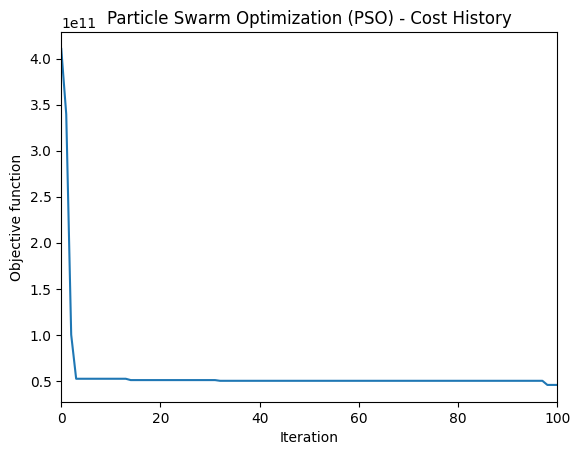

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 243238429253.01233


In [364]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

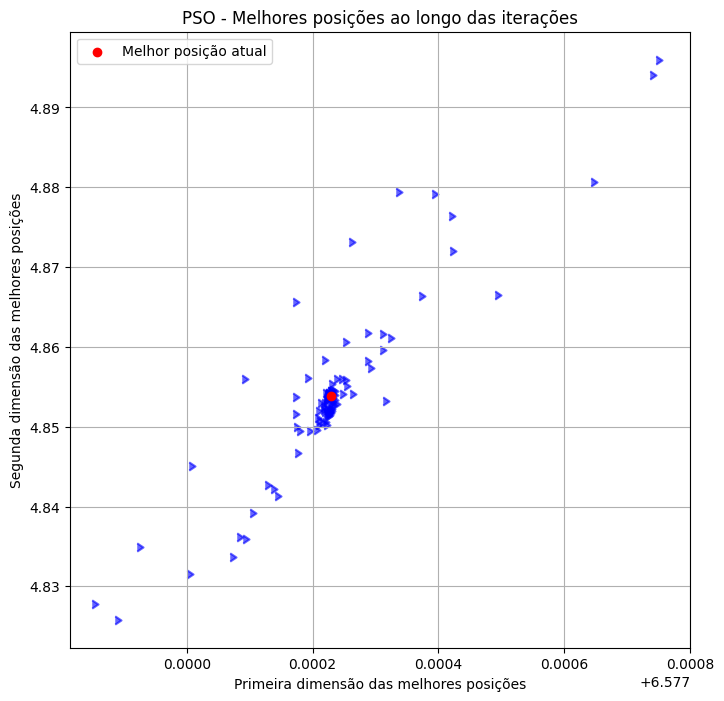

In [365]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker=m, c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()